<a href="https://colab.research.google.com/github/dykwak94/WOD/blob/main/myOwnNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Required Modules, Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
# import required modules, libraries
import numpy as np
import scipy.special
import scipy.misc
from scipy.ndimage import rotate
import matplotlib.pyplot as plt
import os
import re
import imageio
from PIL import Image

## Base structure of 3-layered Neural Network

In [10]:
class neural_network:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # NN layers initialize
        self.inputNodes=input_nodes
        self.hiddenNodes=hidden_nodes
        self.outputNodes=output_nodes

        # NN learningrate initialize
        self.learningRate=learning_rate

        # NN weights initialize
        self.W_ih=np.random.normal(0.0, pow(self.hiddenNodes,-0.5), (self.hiddenNodes, self.inputNodes))
        self.W_ho=np.random.normal(0.0, pow(self.outputNodes,-0.5), (self.outputNodes, self.hiddenNodes))

        # NN activation function
        self.activationFunction = lambda x: scipy.special.expit(x)
        pass

    def train(self, inputs_list, targets_list):
        # train data distribution
        inputs = np.array(inputs_list, ndmin = 2).T
        targets = np.array(targets_list, ndmin = 2).T

        # hidden layer
        hiddenInputs = np.dot(self.W_ih, inputs)
        hiddenOutputs = self.activationFunction(hiddenInputs)

        # output layer
        outputInputs = np.dot(self.W_ho, hiddenOutputs)
        outputOutputs = self.activationFunction(outputInputs)

        # errors
        output_errors = targets - outputOutputs
        hidden_errors = np.dot(self.W_ho.T, output_errors)

        # weight updating
        self.W_ho += self.learningRate * np.dot((output_errors*outputOutputs*(1.0-outputOutputs)), np.transpose(hiddenOutputs))
        self.W_ih += self.learningRate * np.dot((hidden_errors*hiddenOutputs*(1.0-hiddenOutputs)), np.transpose(inputs))
        pass

    def query(self, inputs_list):
        # input layer
        inputs = np.array(inputs_list, ndmin = 2).T

        # hidden layer
        hiddenInputs = np.dot(self.W_ih, inputs)
        hiddenOutputs = self.activationFunction(hiddenInputs)

        # output layer
        outputInputs = np.dot(self.W_ho, hiddenOutputs)
        outputOutputs = self.activationFunction(outputInputs)

        return outputOutputs

## Using MNIST csv Dataset

#### Training Using csv type Dataset
---
_INPUT_:
- train csv file path
- neural network
---

In [11]:
def training_by_csv_session(train_file_path, nn):
    # open file
    train_data_csv = open(f"{train_file_path}", 'r')
    train_data_list = train_data_csv.readlines()[1:]
    train_data_csv.close()

    for bit_image in train_data_list:
            all_values = bit_image.split(',')

            # normalize inputs
            try:
                inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
            except ValueError:
                # pass through exceptional data type
                continue
            # targets one-hot-encoding
            targets = np.zeros(nn.outputNodes) + 0.01
            targets[int(all_values[0])] = 0.99

            # train
            try:
                nn.train(inputs, targets)
            except ValueError:
                # pass through exceptional data type
                continue


#### Testing Using csv type Dataset
---
_INPUT_:
- test csv file path
- neural network

_OUTPUT_:
- accuracy
---

In [22]:
def testing_by_csv_session(test_file_path, nn):

    # open file
    test_data_csv = open(f"{test_file_path}", 'r')
    test_data_list = test_data_csv.readlines()[1:]
    test_data_csv.close()

    score=[]
    for bit_image in test_data_list:
        # preprocessing
        all_values = bit_image.split(',')

        # set desired target level
        correct_label = int(all_values[0])

        # normalize test_inputs
        inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01

        # get test_outputs, actual target level
        outputs = nn.query(inputs)
        label = np.argmax(outputs)

        # compare desired vs actual
        if (label == correct_label):
            score.append(1)
        else:
            score.append(0)

        # calculate accuracy
        accuracy_array = np.asarray(score)
        accuracy= accuracy_array.sum() / accuracy_array.size
    return accuracy

## Using Image type Dataset

#### Image to Normalized Array

In [14]:
def image_data_preprocessing(folder_path):
    # Access to files in google drive folder
    # File names must start with 'img'.
    file_list = [f for f in os.listdir(f"{folder_path}") if f.startswith('img')]

    # Sort the files numerically using a regular expression to extract digits
    file_list.sort(key=lambda x: int(re.search(r'img(\d+)', x).group(1)))

    preprocessed_data = []
    for file_name in file_list:
        file_path = os.path.join(f"{folder_path}", file_name)
        # image preprocessing: change into 28 x 28 array
        img = Image.open(file_path).convert('L')
        img = img.resize((28, 28))  # Resize to 28x28 pixels
        img_array = np.array(img)

        # Flatten into 1d
        img_data = 255-img_array.reshape(784,)

        # normarlize data
        img_data_norm = (img_data / 255.0 * 0.99) + 0.01

        # collect into new array
        preprocessed_data.append(img_data_norm)

        # if you want to see the preprocessed image, execute it
        '''
        plt.imshow(img, cmap='Greys', interpolation='None')
        plt.show()
        '''
    return preprocessed_data

#### Testing Using Image
---
_INPUT_:
- preprocessed image array
- desired target level list
- neural network

_OUTPUT_:
- accuracy
---


In [27]:
def testing_by_image(test_data, desired_list, nn):
    desired = desired_list
    score=[]

    i=0
    for bit_image in test_data:
        # set desired target level
        correct_label=desired[i]

        # set input
        inputs=bit_image

        # get test_outputs, actual target level#
        outputs = nn.query(inputs)
        label = np.argmax(outputs)

        # compare desired vs actual
        if (label == correct_label):
            score.append(1)
        else:
            score.append(0)
        i+=1

        # calculate accuracy
        accuracy_array = np.asarray(score)
        accuracy= accuracy_array.sum() / accuracy_array.size
    return accuracy

### Training Using Rotated Image Dataset
---
_INPUT_:
- preprocessed image array
-rotating angle (+,-)

_OUTPUT_:
- rotated image array
---

In [59]:
def rotate_image(image_array, angle):
    rotated_data = []

    for image in image_array:
        # rotate image in array scale
        temp=scipy.ndimage.interpolation.rotate(image.reshape(28,28), angle, cval = 0.01, reshape = False).reshape(784)

        # make rotated image array
        rotated_data.append(temp)

    return rotated_data

In [70]:
def training_by_image_session(train_data_list, nn, desired_list):
    i=0
    for bit_image in train_data_list:
       # set inputs
        inputs=bit_image

        # targets one-hot-encoding
        targets = np.zeros(nn.outputNodes) + 0.01
        targets[int(desired_list[i])] = 0.99
        i+=1

        # train
        try:
            nn.train(inputs, targets)
        except ValueError:
            # pass through exceptional data type
            continue



## Assignment 1

In [23]:
# NN construction
input_nodes = 784
hidden_nodes = 200
output_nodes = 10
learning_rate_1 = 0.1
learning_rate_2 = 0.2

NN1 = neural_network(input_nodes, hidden_nodes, output_nodes, learning_rate_1)
NN2 = neural_network(input_nodes, hidden_nodes, output_nodes, learning_rate_2)

# total epochs = 20, train & test NN1, NN2
desired=[1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0]
NN1_csv_csv=dict()
NN1_csv_image=dict()
NN2_csv_csv=dict()
NN2_csv_image=dict()

In [24]:
print("NN1 trained by csv, tested by csv")
for epoch in range(1,21):
    training_by_csv_session("/content/drive/MyDrive/mnist_train.csv", NN1)
    test_result = testing_by_csv_session("/content/drive/MyDrive/mnist_test.csv", NN1)
    NN1_csv_csv[f"{epoch}"]=test_result
    print(f"epoch: {epoch}", "accuracy: ", test_result)

NN1 trained by csv, tested by csv
epoch: 1 accuracy:  0.9578
epoch: 2 accuracy:  0.9682
epoch: 3 accuracy:  0.9723
epoch: 4 accuracy:  0.9742
epoch: 5 accuracy:  0.9734
epoch: 6 accuracy:  0.9741
epoch: 7 accuracy:  0.9744
epoch: 8 accuracy:  0.9748
epoch: 9 accuracy:  0.9733
epoch: 10 accuracy:  0.9737
epoch: 11 accuracy:  0.9725
epoch: 12 accuracy:  0.9729
epoch: 13 accuracy:  0.9729
epoch: 14 accuracy:  0.9729
epoch: 15 accuracy:  0.9724
epoch: 16 accuracy:  0.9715
epoch: 17 accuracy:  0.9715
epoch: 18 accuracy:  0.971
epoch: 19 accuracy:  0.9706
epoch: 20 accuracy:  0.9705


In [28]:
print("NN1 trained by csv, tested by my own image")
for epoch in range(1,21):
    training_by_csv_session("/content/drive/MyDrive/mnist_train.csv", NN1)
    test_result = testing_by_image(image_data_preprocessing("/content/drive/MyDrive/hand"), desired, NN1)
    NN1_csv_image[f"{epoch}"]=test_result
    print(f"epoch: {epoch}", "accuracy: ", test_result)

NN1 trained by csv, tested by my own image
epoch: 1 accuracy:  0.72
epoch: 2 accuracy:  0.7266666666666667
epoch: 3 accuracy:  0.7066666666666667
epoch: 4 accuracy:  0.7
epoch: 5 accuracy:  0.7133333333333334
epoch: 6 accuracy:  0.7066666666666667
epoch: 7 accuracy:  0.6866666666666666
epoch: 8 accuracy:  0.7066666666666667
epoch: 9 accuracy:  0.7133333333333334
epoch: 10 accuracy:  0.7133333333333334
epoch: 11 accuracy:  0.7066666666666667
epoch: 12 accuracy:  0.72
epoch: 13 accuracy:  0.7133333333333334
epoch: 14 accuracy:  0.7
epoch: 15 accuracy:  0.7
epoch: 16 accuracy:  0.6933333333333334
epoch: 17 accuracy:  0.6933333333333334
epoch: 18 accuracy:  0.6733333333333333
epoch: 19 accuracy:  0.68
epoch: 20 accuracy:  0.68


In [29]:
print("NN2 trained by csv, tested by csv")
for epoch in range(1,21):
    training_by_csv_session("/content/drive/MyDrive/mnist_train.csv", NN2)
    test_result= testing_by_csv_session("/content/drive/MyDrive/mnist_test.csv", NN2)
    NN2_csv_csv[f"{epoch}"]=test_result
    print(f"epoch: {epoch}", "accuracy: ", test_result)

NN2 trained by csv, tested by csv
epoch: 1 accuracy:  0.9594
epoch: 2 accuracy:  0.9655
epoch: 3 accuracy:  0.9653
epoch: 4 accuracy:  0.9662
epoch: 5 accuracy:  0.9658
epoch: 6 accuracy:  0.9662
epoch: 7 accuracy:  0.9689
epoch: 8 accuracy:  0.9695
epoch: 9 accuracy:  0.9656
epoch: 10 accuracy:  0.9652
epoch: 11 accuracy:  0.9672
epoch: 12 accuracy:  0.9654
epoch: 13 accuracy:  0.9648
epoch: 14 accuracy:  0.965
epoch: 15 accuracy:  0.9646
epoch: 16 accuracy:  0.9627
epoch: 17 accuracy:  0.963
epoch: 18 accuracy:  0.9603
epoch: 19 accuracy:  0.9612
epoch: 20 accuracy:  0.9632


In [30]:
print("NN2 trained by csv, tested by my own image")
for epoch in range(1,21):
    training_by_csv_session("/content/drive/MyDrive/mnist_train.csv", NN2)
    test_result = testing_by_image(image_data_preprocessing("/content/drive/MyDrive/hand"), desired, NN2)
    NN2_csv_image[f"{epoch}"]=test_result
    print(f"epoch: {epoch}", "accuracy: ", test_result)

NN2 trained by csv, tested by my own image
epoch: 1 accuracy:  0.6333333333333333
epoch: 2 accuracy:  0.62
epoch: 3 accuracy:  0.6533333333333333
epoch: 4 accuracy:  0.6533333333333333
epoch: 5 accuracy:  0.6333333333333333
epoch: 6 accuracy:  0.6266666666666667
epoch: 7 accuracy:  0.6533333333333333
epoch: 8 accuracy:  0.68
epoch: 9 accuracy:  0.6666666666666666
epoch: 10 accuracy:  0.64
epoch: 11 accuracy:  0.64
epoch: 12 accuracy:  0.6266666666666667
epoch: 13 accuracy:  0.6266666666666667
epoch: 14 accuracy:  0.64
epoch: 15 accuracy:  0.6466666666666666
epoch: 16 accuracy:  0.66
epoch: 17 accuracy:  0.6533333333333333
epoch: 18 accuracy:  0.6266666666666667
epoch: 19 accuracy:  0.62
epoch: 20 accuracy:  0.6


#### Test Result (using MNIST test data)

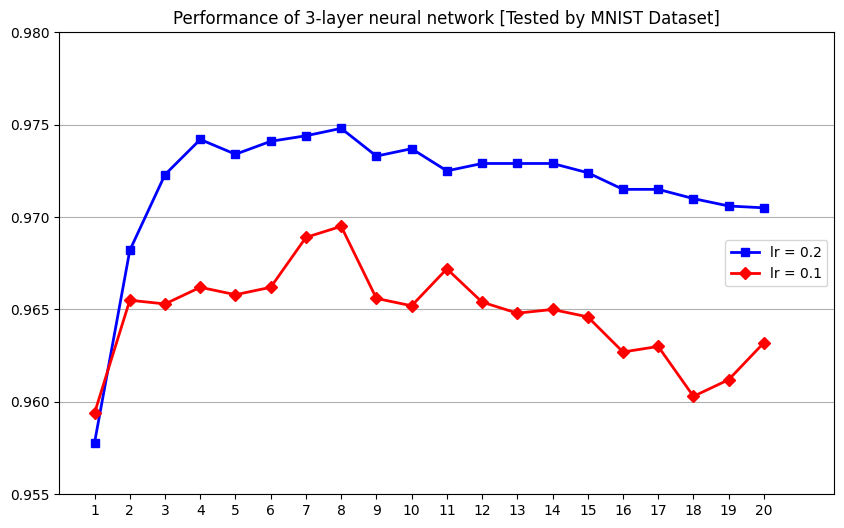

In [51]:
epochs1 = list(NN1_csv_csv.keys())
test_results1 = list(NN1_csv_csv.values())

epochs2 = list(NN2_csv_csv.keys())
test_results2 = list(NN2_csv_csv.values())

# Creating a line plot
plt.figure(figsize=(10, 6))
plt.plot(epochs1, test_results1, marker='s', color='blue', linewidth=2, label='lr = 0.2')
plt.plot(epochs2, test_results2, marker='D', color='red', linewidth=2, label='lr = 0.1')

plt.title("Performance of 3-layer neural network [Tested by MNIST Dataset]")
plt.grid(axis='y')
plt.legend(loc='center right')
plt.ylim(0.955, 0.98)
plt.xlim(-1, 21)

# Showing the plot
plt.show()

#### Test Result (using my own image)

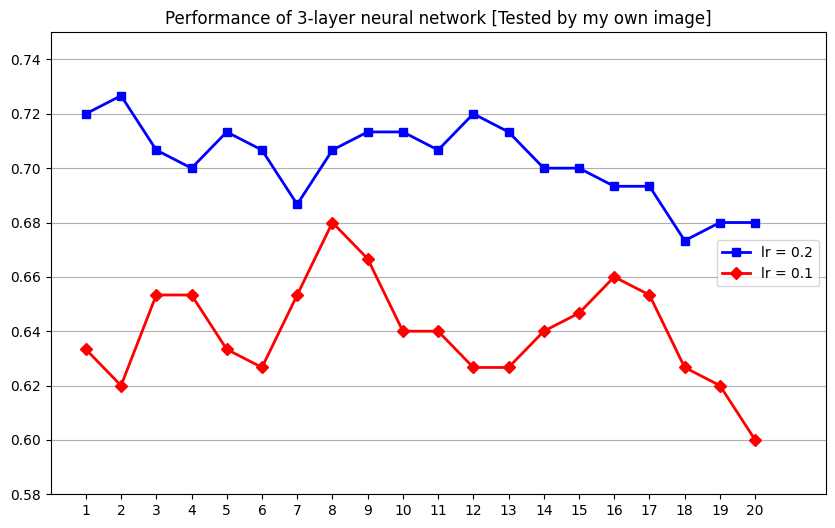

In [48]:
epochsA = list(NN1_csv_image.keys())
test_resultsA = list(NN1_csv_image.values())

epochsB = list(NN2_csv_image.keys())
test_resultsB = list(NN2_csv_image.values())

# Creating a line plot
plt.figure(figsize=(10, 6))
plt.plot(epochsA, test_resultsA, marker='s', color='blue', linewidth=2, label='lr = 0.2')
plt.plot(epochsB, test_resultsB, marker='D', color='red', linewidth=2, label='lr = 0.1')

plt.title("Performance of 3-layer neural network [Tested by my own image]")
plt.grid(axis='y')
plt.legend(loc='center right')
plt.ylim(0.58, 0.75)
plt.xlim(-1, 21)

# Showing the plot
plt.show()



## Assignment 2

In [76]:
# NN construction
input_nodes = 784
hidden_nodes = 200
output_nodes = 10
learning_rate = 0.1

NN = neural_network(input_nodes, hidden_nodes, output_nodes, learning_rate)
desired1=[1,2,3,4,5,6,7,8,9,0]*30
NN_image_csv_2=dict()
NN_image_csv_4=dict()
NN_image_csv_6=dict()
NN_image_csv_8=dict()
NN_image_csv_10=dict()

In [79]:
for deg in range(0,31,3):
    # add rotated data
    rotated = rotate_image(image_data_preprocessing("/content/drive/MyDrive/hand"), deg)
    added=rotated+image_data_preprocessing("/content/drive/MyDrive/hand")

    # train
    training_by_image_session(added, NN, desired1)

    # test
    for epoch in range(2, 10, 2):
        training_by_image_session(rotated, NN, desired1)
        test_result= testing_by_csv_session("/content/drive/MyDrive/mnist_test.csv", NN)
        globals()["NN_image_csv_{}".format(epoch)][f"{deg}"]=test_result
    print(f"angle: {deg}", "accuracy: ", test_result)

<ipython-input-59-420d4a83a0c1>:6: DeprecationWarning: Please import `rotate` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  temp=scipy.ndimage.interpolation.rotate(image.reshape(28,28), angle, cval = 0.01, reshape = False).reshape(784)


angle: 0 accuracy:  0.5114
angle: 3 accuracy:  0.5151
angle: 6 accuracy:  0.5124
angle: 9 accuracy:  0.5116
angle: 12 accuracy:  0.5084
angle: 15 accuracy:  0.5044
angle: 18 accuracy:  0.4981
angle: 21 accuracy:  0.4902
angle: 24 accuracy:  0.4832
angle: 27 accuracy:  0.4769
angle: 30 accuracy:  0.4678


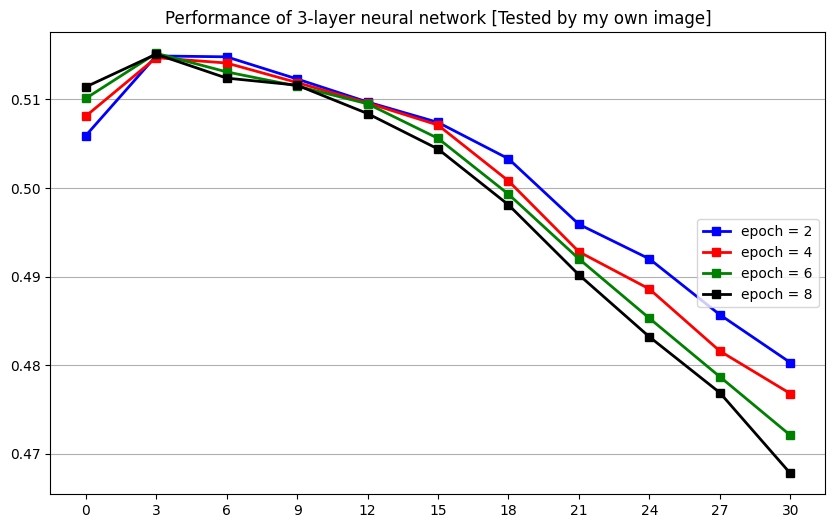

In [82]:
plt.figure(figsize=(10, 6))
colors=['blue','red','green','black','yellow']

# Creating each line plot
i=0
for epoch in range(2, 10, 2):
    degrees = list(globals()["NN_image_csv_{}".format(epoch)].keys())
    test_results = list(globals()["NN_image_csv_{}".format(epoch)].values())

    plt.plot(degrees, test_results, marker='s', color=colors[i], linewidth=2, label=f'epoch = {epoch}')
    i+=1

plt.title("Performance of 3-layer neural network [Tested by my own image]")
plt.grid(axis='y')
plt.legend(loc='center right')

# Showing the plot
plt.show()
